# Paired t-test between groups - Spectrograms

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import os
import mat73
import mne
from mne.time_frequency import tfr_morlet
import pandas as pd
import scipy.io as io
from numpy import loadtxt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import sklearn.metrics.pairwise as pairwise
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import sys
sys.path.append('/data/dian/Dropbox/scripts/Stanford/ThalamocoricalLoop-project/utils') 
import customFunctions
import importlib
importlib.reload(customFunctions)
from customFunctions import *

In [3]:
os.chdir('/data/dian/Dropbox/Stanford_Matters/data/THAL/CCEP/results/explore5_locked')

In [4]:
metaT = pd.read_csv('table_CCEPnewpipOutput_wholebrain_anatomical_info_activationRedone2.csv')
metaT.head()

,subject,aSubID,block_name,stim_chan,record_chan,sc1,sc2,rc1,rc2,stim_shank,...,pks_time_3,pks_time_4,pks_time_5,pks_time_6,pks_time_7,pks_time_8,pks_time_9,pks_time_10,pks_time_11,pks_time_12
0,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF1-LORF2,LPCN1,LPCN2,LORF1,LORF2,0,...,460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF2-LORF3,LPCN1,LPCN2,LORF2,LORF3,0,...,442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF3-LORF4,LPCN1,LPCN2,LORF3,LORF4,0,...,73.0,167.0,476.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF4-LORF5,LPCN1,LPCN2,LORF4,LORF5,0,...,157.0,454.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF5-LORF6,LPCN1,LPCN2,LORF5,LORF6,0,...,444.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Activated spectra minus non-activated spectra for each individual

In [5]:
sblist = metaT.subject.unique()
sblist = np.delete(sblist, np.where(sblist=='S23_196_HL'))
print(sblist.shape)
print(sblist)
mat = mergeMat(sblist, keys=['filteridx_metaT','Vrpw','Vrpc', 'Vrph'],
              inputDir = 'UMAP_learn/resample3')
n1=mat['Vrpw'].shape[1]
n2=mat['Vrpc'].shape[1]

(26,)
['S21_166_TM' 'S21_167_MQ' 'S21_169_BH' 'S21_170_JL' 'S21_171_MM'
 'S21_172_KS' 'S22_176_LB' 'S22_177_JM' 'S22_178_AF' 'S22_181_CB'
 'S22_182_DH' 'S22_183_CR' 'S22_185_TW' 'S22_188_CB' 'S22_189_LMA'
 'S22_190_AS' 'S22_192_LG' 'S22_193_AM' 'S23_194_PS' 'S23_195_MZ'
 'S23_197_TA' 'S23_198_JP' 'S23_199_GB' 'S23_201_JG' 'S23_202_KC'
 'S23_205_LLC']


In [6]:
dirbase = '/home/dian/Desktop/THAL/UMAP'
anot = np.array([])
for sb in sblist:
    fn = dirbase+'/WITHINSBJ_semisupervise/actLearn_2clusters_anot_%s.txt' %sb
    content = np.loadtxt(fn).astype(np.int64)
    anot = np.concatenate((anot, content), axis=0)

In [7]:
anot = np.array(anot)
actIdx = np.where(anot == 2)[0] # NOTE: 'anot' is already filteridx_metaT filtered!
noactIdx = np.where(anot == 1)[0]

print(len(actIdx))

dat0 = np.concatenate((mat['Vrpw'], mat['Vrpc']), axis=1)
print(dat0.shape)

# loop through each stimulation channel, to get the activation pattern contracted with the non-activated pattern; 
#i.e. using each channel's non-activation pattern as control
allsublist = metaT['subject'][mat['filteridx_metaT'][:,0]].tolist()
allstimlist = metaT['stim_chan'][mat['filteridx_metaT'][:,0]].tolist()
allstimID = [i+' '+j for i,j in zip(allsublist, allstimlist)]


80791
(249893, 2580)


In [8]:
dat0_res = dat0.copy()
N_noact = [] # each case corresponding to a stimID - check for unstable pattern when the number to average is too low
N_actrate = []
for stimID in set(allstimID):
    stimIdx = set(np.where(np.array(allstimID) == stimID)[0])
    sactIdx = list(stimIdx.intersection(actIdx))
    snonIdx = list(stimIdx.intersection(noactIdx))
    actrate = len(sactIdx)/len(stimIdx)
    
    dat0_res[sactIdx,:] = dat0[sactIdx,:] - np.nanmean(dat0[snonIdx,:], axis = 0) #subtract row vector from matrix
    N_noact.append(len(snonIdx))
    N_actrate.append(actrate)
    

/tmp/ipykernel_3805996/1360297360.py:10: RuntimeWarning: Mean of empty slice
  dat0_res[sactIdx,:] = dat0[sactIdx,:] - np.nanmean(dat0[snonIdx,:], axis = 0) #subtract row vector from matrix


In [9]:
print(dat0_res.shape)
print(len(anot))
print(len(actIdx))
#del dat0

(249893, 2580)
249893
80791


In [12]:
stimID_exclude  = 'S21_167_MQ RE1-RE2'
estimIdx = set(np.where(np.array(allstimID) == stimID_exclude)[0])
esactIdx = estimIdx.intersection(actIdx)
# exclude 'S21_167_MQ RE1-RE2' as it has too few inactivated cases = 5
actIdx = set(actIdx) - esactIdx
actIdx = list(actIdx)
len(actIdx)

80673

In [11]:
# finalize preparing input data and anatomical information
dat = dat0_res[actIdx,:]
filterIdx = mat['filteridx_metaT'][actIdx,0]
T = metaT.iloc[filterIdx,].reset_index()
cleanfilter = (T.sCrossBorder==0) & (T.rCrossBorder==0) & (T.eudDist>5)
# clean data
dat = dat[cleanfilter,:]
T = T.loc[cleanfilter,].reset_index()
# get connectivity information
hemis = list(map(detHemi,
                 T.MNIout_coord_1.tolist(), T.MNIin_coord_1.tolist()
          ))
df = pd.DataFrame({'anatomy_conn': list(map(lambda x,y:'-'.join(str(e) for e in [x,y]),
                  cortexLab(T.JP_label_out.tolist()),
                  cortexLab(T.JP_label_in.tolist()))),#,
                 # metaT.activated.tolist())),
                   'hemis':hemis
                  })
df['anatomy_from'] = cortexLab(T.JP_label_out.tolist())
df['anatomy_to']   = cortexLab(T.JP_label_in.tolist())
df['anatomy_fromTHAL'] = thalLab(T.JP_label_out.tolist())
df['anatomy_toTHAL'] = thalLab(T.JP_label_in.tolist())

crossNet_cat = ['internet','intranet']
df['crossNet_bin'] = list(map(lambda x,y:crossNet_cat[int(x==y)],
                         T.Yeo7_out2, T.Yeo7_in2))
df['crossNet'] = list(map(lambda x,y:'-'.join(str(e) for e in [x,y]),
                         T.Yeo7_out2, T.Yeo7_in2))
df['Hemi-crossNet_bin'] = list(map(lambda x,y:'-'.join(str(e) for e in [x,y]),
                  df['hemis'],
                  df['crossNet_bin']
                         ))
df['anatomy_from-hemi'] = df['anatomy_from'].str.cat(df['hemis'], sep='-')
df['anatomy_conn-hemi'] = df['anatomy_conn'].str.cat(df['hemis'], sep='-')

# exclude some ROIs
excludeROI = np.invert(df['anatomy_conn'].str.contains('others'))
df = df.loc[excludeROI,].reset_index()
print(len(df))
dat = dat[excludeROI,:]

58598


In [13]:
print(dat.shape)

(58598, 2580)


In [15]:
# save input data for future loading
#np.save('UMAP/ALLDATA_semisupervise/input_dat1_untransformed.npy',dat)
# save as a mat file
#dat_dic = {'dat': dat}
#io.savemat( 'UMAP/ALLDATA_semisupervise/input_dat1_untransformed.mat',dat_dic)

In [14]:
# import results from UMAP supervised training using anatomical information
brainInfo = pd.read_csv('UMAP/ALLDATA_semisupervise/brainInfo.csv')

In [15]:
isnoise = loadtxt('UMAP/ALLDATA_semisupervise/isnoise.txt',
                delimiter="\t")
cleanFeatures = loadtxt('UMAP/ALLDATA_semisupervise/cleanFeatures.txt',
                delimiter="\t",dtype='str')

In [16]:
ftypes = list(set(cleanFeatures))
print(ftypes)

['COR-ipsi', 'THAL-ipsi', 'THAL-contr', 'COR-contr']


In [18]:
def tscore_1sample(X):
    '''
    assume X is a 2D matrix (sample size * n-datapoints of 1 sample)
    '''
    n = X.shape[0]
    t = np.mean(X,axis=0)/(np.std(X,axis=0)/np.sqrt(n))
    return t

def tscore_2sample(x1,x2):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    s1 = np.std(x1,axis=0)
    s2 = np.std(x2,axis=0)
    sp = np.sqrt(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-2)) # pooled standard deviation
    t = (np.mean(x1,axis=0)-np.mean(x2,axis=0))/(sp*np.sqrt(1/n1 + 1/n2))
    return t

def contrast_2sample(x1,x2):
    return np.mean(x1,axis=0)-np.mean(x2,axis=0)
    

def zscore_1sample(X):
    '''
    assume X is a 2D matrix (sample size * n-datapoints of 1 sample)
    '''
    n = X.shape[0]
    z = (X-np.mean(X,axis=0))/(np.std(X,axis=0))
    return z


In [32]:
def MNE1SampleSpectraSigTest(d1, threshold='auto', outname= 'tmp.mat', ifplot=1,  n_permutations = 5000, ifsave=0):
    # convert vector to time-freq matrix
    n1=mat['Vrpw'].shape[1] # 1380
    n2=mat['Vrpc'].shape[1] # 1200
    ntime = 60
    #
    pw1 = d1[:, 0:n1].reshape(d1.shape[0],ntime, -1) 
    pc1 = d1[:, n1:(n1+n2)].reshape(d1.shape[0],ntime, -1)
  
   # COMPUTE ADJACENCY MATRIX
    adjacency = mne.stats.combine_adjacency(pw1.shape[1], pw1.shape[2]) #  times, freqs

    # We want a one-tailed test
    tail = 1
    degrees_of_freedom = d1.shape[0] - 1
    if threshold=='auto':
        t_thresh = scipy.stats.t.ppf(1 - 0.001/2, df=degrees_of_freedom)
    else:
        t_thresh = threshold
    print('Initial cluster threshold is %s'%(t_thresh))
    print('Degrees of freedom is %d' % (degrees_of_freedom))


    # Run the analysis
    T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(
        pw1, n_jobs=-1,
        n_permutations=n_permutations,
        threshold=t_thresh,
        tail=tail,
        adjacency=adjacency,
        out_type="mask",
        verbose=True
    )
    T_obs_plot = np.nan * np.ones_like(T_obs)
    
    
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.01:
            T_obs_plot[c] = T_obs[c]
            
    t_idx, f_idx = np.unravel_index(
            np.nanargmax(np.abs(T_obs_plot)), pw1.shape[1:]
        )

    if ifplot==1:
        plt.close()
        plt.figure()
        plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

        vmax = np.max(np.abs(T_obs))
        vmin = -vmax
        plt.close()
        plt.figure()
        plt.imshow(
            np.transpose(T_obs),
            cmap=plt.cm.gray,
           # extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect="auto",
            origin="lower",
            vmin=vmin,
            vmax=vmax,
        )

        plt.imshow(
            np.transpose(T_obs_plot),
            cmap=plt.cm.RdBu_r,
         #   extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect="auto",
            origin="lower",
            vmin=vmin,
            vmax=vmax,
        )
        plt.colorbar()
        plt.xlabel("Time (custome unit)")
        plt.ylabel("Frequency (custome unit)")
        #plt.title(f"Induced power ({tfr_epochs.ch_names[ch_idx]})")
        plt.show()
    
    sigClsts = {"T_obs":T_obs, "clusters":np.array(clusters), "cluster_p_values":cluster_p_values, "H0":H0,
                   "T_obs_thr":T_obs_plot, 't_idx':t_idx, 'f_idx':f_idx}
        
    if ifsave==1:
        # save significant clusters
          io.savemat("GroupLevel_SigTest/"+outname, sigClsts)
        
    return sigClsts

In [19]:
def MNE2SampleSpectraSigTest(d1, d2, threshold, outname= 'tmp.mat', ifplot=1,  n_permutations = 5000, ifsave=0):
    # convert vector to time-freq matrix
    n1=mat['Vrpw'].shape[1] # 1380
    n2=mat['Vrpc'].shape[1] # 1200
    ntime = 60
    #
    pw1 = d1[:, 0:n1].reshape(d1.shape[0],ntime, -1) 
    pc1 = d1[:, n1:(n1+n2)].reshape(d1.shape[0],ntime, -1)
    #
    pw2 = d2[:, 0:n1].reshape(d2.shape[0],ntime, -1) 
    pc2 = d2[:, n1:(n1+n2)].reshape(d2.shape[0],ntime, -1)
    
    # plot
    # plot to check data
    if ifplot==1:
        plotSpectra2Groups(np.rot90(np.nanmean(pw1, axis=0)),
                           np.rot90(np.nanmean(pw2, axis=0)))
        
   # COMPUTE ADJACENCY MATRIX
    adjacency = mne.stats.combine_adjacency(pw1.shape[1], pw1.shape[2]) #  times, freqs

    # We want a two-tailed test
    tail = 0

    # Set the number of permutations to run.
    # Warning: 50 is way too small for a real-world analysis (where values of 5000
    # or higher are used), but here we use it to increase the computation speed.
   

    # Run the analysis
    F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
        [pw1,pw2], n_jobs=-1,
        n_permutations=n_permutations,
        threshold=threshold,
        tail=tail,
        adjacency=adjacency,
        out_type="mask",
        verbose=True
    )
    F_obs_plot = np.nan * np.ones_like(F_obs)
    
    
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.01:
            F_obs_plot[c] = F_obs[c]
            
    t_idx, f_idx = np.unravel_index(
            np.nanargmax(np.abs(F_obs_plot)), pw1.shape[1:]
        )

    if ifplot==1:
        plt.figure()
        plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

        vmax = np.max(np.abs(F_obs))
        vmin = -vmax
        plt.close()
        plt.figure()
        plt.imshow(
            np.transpose(F_obs),
            cmap=plt.cm.gray,
           # extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect="auto",
            origin="lower",
            vmin=vmin,
            vmax=vmax,
        )

        plt.imshow(
            np.transpose(F_obs_plot),
            cmap=plt.cm.RdBu_r,
         #   extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect="auto",
            origin="lower",
            vmin=vmin,
            vmax=vmax,
        )
        plt.colorbar()
        plt.xlabel("Time (custome unit)")
        plt.ylabel("Frequency (custome unit)")
        #plt.title(f"Induced power ({tfr_epochs.ch_names[ch_idx]})")
        plt.show()
    
    sigClsts = {"F_obs":F_obs, "clusters":np.array(clusters), "cluster_p_values":cluster_p_values, "H0":H0,
                   "F_obs_thr":F_obs_plot, 't_idx':t_idx, 'f_idx':f_idx}
        
    if ifsave==1:
        # save significant clusters
        io.savemat("GroupLevel_SigTest/"+outname, sigClsts)
        
    return sigClsts
    
def plotSpectra2Groups(dshow1,dshow2):
    plt.close()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))

    sp1 = ax1.imshow(dshow1, aspect=2.1)
    ax1.set_title('mean power (group1)', fontsize=10)
    #ax1.set(xticks=np.arange(0, 65)[::20], xticklabels=np.arange(-25, 650)[::200]);
    ax1.tick_params( labelsize=10)
    plt.colorbar(sp1,shrink=0.6)

    sp2 = ax2.imshow(dshow2, aspect=2.1)
    ax2.set_title('mean power (group2)', fontsize=10)
    #ax2.set(xticks=np.arange(0, 65)[::20], xticklabels=np.arange(-25, 650)[::200]);
    ax2.tick_params( labelsize=10)
    plt.colorbar(sp2,shrink=0.6)

    sp3 = ax3.imshow(dshow1-dshow2,
                     aspect=2.1, cmap='RdBu_r')
    ax3.set_title('mean power differences', fontsize=10)
    #ax2.set(xticks=np.arange(0, 65)[::20], xticklabels=np.arange(-25, 650)[::200]);
    ax3.tick_params(labelsize=10)
    plt.colorbar(sp3,shrink=0.6)
    plt.show()
    

### Within-subject cluster permutation test between COR-ipsi vs THAL-ipsi

In [92]:
it1 = 1
it2 = 0
print('Group1: %s'%(ftypes[it1]))
filterBoolean = (cleanFeatures==ftypes[it1])&( isnoise==0) 
brain_info1 = brainInfo[filterBoolean]
print(brain_info1.shape)
d1_ = dat[filterBoolean]
print(d1_.shape)

print('Group2: %s'%(ftypes[it2]))
filterBoolean = (cleanFeatures==ftypes[it2])&( isnoise==0) 
brain_info2 = brainInfo[filterBoolean]
print(brain_info2.shape)
d2_ = dat[filterBoolean]
print(d2_.shape)
# impute missing data
# Preprocess - simulate nan values, which are few
pipe = make_pipeline(SimpleImputer(strategy="mean"))
d1 = pipe.fit_transform(d1_.copy())
d2 = pipe.fit_transform(d2_.copy())

Group1: THAL-ipsi
(5209, 73)
(5209, 2580)
Group2: COR-ipsi
(39463, 73)
(39463, 2580)


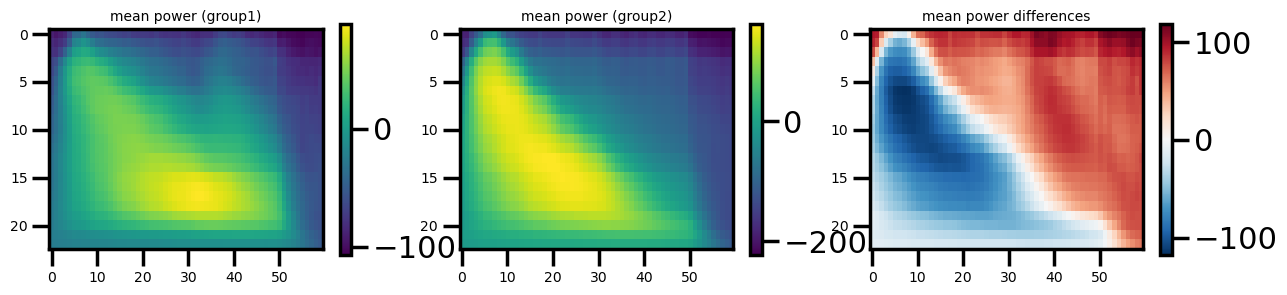

In [93]:
ntime=60
tG1 = tscore_1sample(d1)
tG2 = tscore_1sample(d2)
plotSpectra2Groups(np.rot90(tG1[0:n1].reshape(ntime, -1)),
                   np.rot90(tG2[0:n1].reshape(ntime, -1)))

In [25]:
ftypes

['COR-ipsi', 'THAL-ipsi', 'THAL-contr', 'COR-contr']

(array([ 73., 237., 306., 239., 259., 199., 222., 369., 354., 147.,  48.,
         35.,  22.,  22.,  15.,  10.,   7.,   5.,   7.,   4.]),
 array([0.18677087, 0.25667421, 0.32657754, 0.39648087, 0.46638421,
        0.53628754, 0.60619088, 0.67609421, 0.74599755, 0.81590088,
        0.88580421, 0.95570755, 1.02561088, 1.09551422, 1.16541755,
        1.23532089, 1.30522422, 1.37512755, 1.44503089, 1.51493422,
        1.58483756]),
 <BarContainer object of 20 artists>)

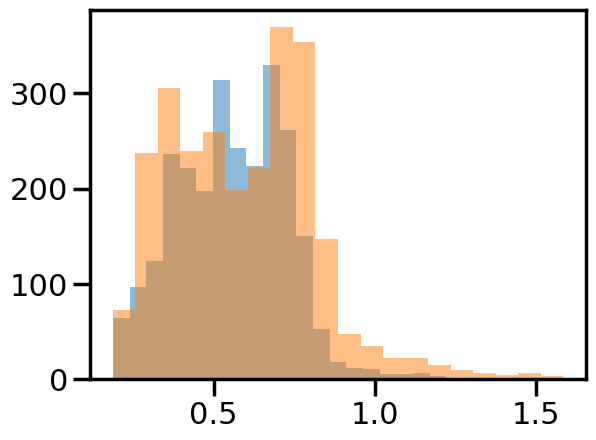

In [27]:
# check variance of two groups to be compared
d1_vars = np.var(d1, axis=0)
d2_vars = np.var(d2, axis=0)
plt.close()
plt.figure()
plt.hist(d1_vars, bins=20, alpha=0.5)
plt.hist(d2_vars,bins=20, alpha=0.5)

In [94]:
withinsb_Tscores = []

for i,sb in enumerate(sblist):
    idx1 = np.where(brain_info1.subject==sb)[0]
    if idx1.shape[0]==0:
        print(sb+' does not have group1 data...')
        continue
    
    idx2 = np.where(brain_info2.subject==sb)[0]
    if idx2.shape[0]==0:
        print(sb+' does not have group2 data...')
        continue
        
    sbd1 = d1[idx1,:]
    sbd2 = d2[idx2,:]
    sbt = tscore_2sample(sbd1,sbd2)
    #sbt = tscore_1sample(sbd1)-tscore_1sample(sbd2)
    withinsb_Tscores.append(sbt) # within-subject comparison of t-scores of each categories
    
withinsb_Tscores = np.array(withinsb_Tscores)

S22_192_LG does not have group1 data...


In [29]:
withinsb_Tscores.shape

(25, 2580)

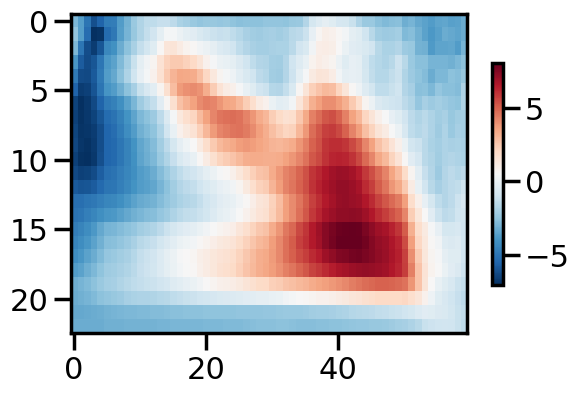

In [30]:
plt.close()
plt.figure()
dat2show = rotate(np.mean(withinsb_Tscores[:,0:n1],axis=0).reshape(ntime, -1))
p = plt.imshow(dat2show, aspect=2.1, cmap='RdBu_r')
plt.colorbar(p,shrink=0.6)

Initial cluster threshold is 6
Degrees of freedom is 24
stat_fun(H1): min=-11.061795 max=9.705291
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

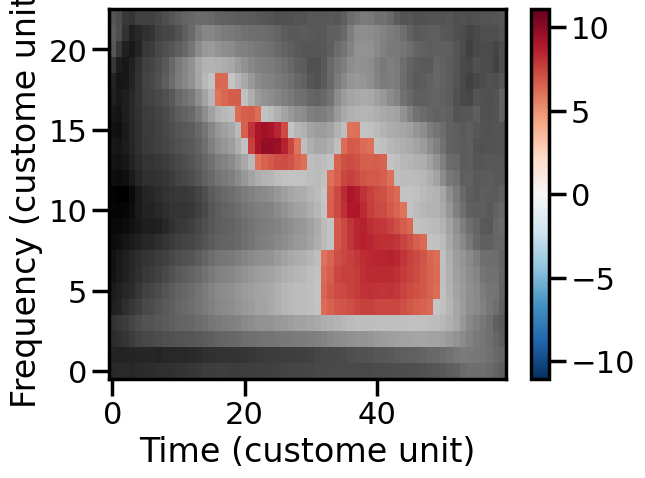

{'T_obs': array([[-7.492432  , -7.93887007, -7.11569725, ..., -3.49638684,
         -3.0462831 , -3.64047342],
        [-7.39558536, -7.95297448, -6.91013686, ..., -6.13173466,
         -4.28666969, -4.36261331],
        [-7.39010903, -7.91332625, -6.55711495, ..., -8.18118688,
         -6.69760224, -6.08619032],
        ...,
        [-1.7892963 , -1.31424346, -1.44735178, ..., -4.50860319,
         -4.20424546, -3.80488   ],
        [-2.34793682, -1.83048794, -2.21038399, ..., -5.15241959,
         -4.21720054, -3.68839005],
        [-2.94966435, -2.332216  , -3.10621254, ..., -4.15820502,
         -3.65317497, -3.38872583]]),
 'clusters': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False

In [34]:
# run test
MNE1SampleSpectraSigTest(withinsb_Tscores, ifsave=1, threshold=6,
                         outname='mnePermutationClusterTest_sigClsts_withinsbjTscores_%svs%s.mat'%(ftypes[it1],ftypes[it2]))

### Within-subject cluster permutation test between other groups

In [42]:
ftypes

['COR-ipsi', 'THAL-ipsi', 'THAL-contr', 'COR-contr']

Group1: THAL-ipsi
(5209, 2580)
Group2: THAL-contr
(619, 2580)
S21_166_TM does not have group2 data...
S21_167_MQ does not have group2 data...
S21_170_JL does not have group2 data...
S22_176_LB does not have group2 data...
S22_190_AS does not have group2 data...
S22_192_LG does not have group1 data...
Initial cluster threshold is 5
Degrees of freedom is 19
stat_fun(H1): min=-8.088826 max=6.799952
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

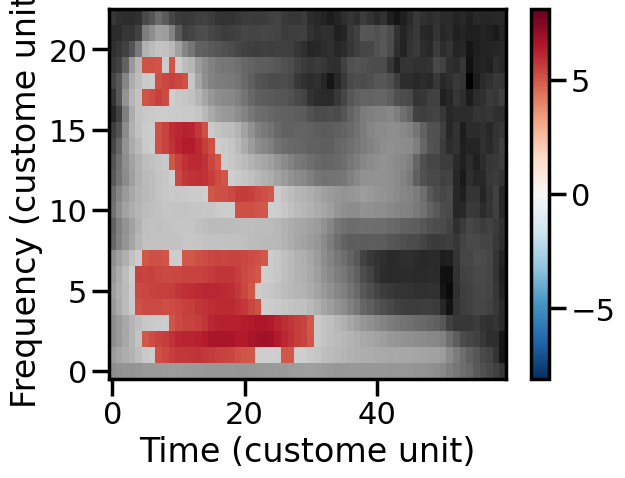

{'T_obs': array([[ 0.82653349,  1.77503162,  0.87477512, ..., -4.96967412,
         -5.21308772, -4.59803384],
        [ 1.10875023,  2.38310491,  1.6250161 , ..., -4.60286888,
         -5.20571634, -5.116087  ],
        [ 1.23719628,  2.87598056,  2.476839  , ..., -4.01662813,
         -4.6406346 , -5.29955208],
        ...,
        [-3.45529954, -3.77824615, -5.16092012, ..., -5.79738427,
         -5.94176059, -5.6692979 ],
        [-3.96711517, -4.75812768, -5.15650062, ..., -5.68269577,
         -6.40980274, -5.55380848],
        [-4.65959072, -6.72318301, -6.65328468, ..., -5.46165082,
         -5.74012336, -5.49858933]]),
 'clusters': array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False

In [91]:
it1 = 1
it2 = 2
print('Group1: %s'%(ftypes[it1]))
filterBoolean = (cleanFeatures==ftypes[it1])&( isnoise==0) 
brain_info1 = brainInfo[filterBoolean]
d1_ = dat[filterBoolean]
print(d1_.shape)

print('Group2: %s'%(ftypes[it2]))
filterBoolean = (cleanFeatures==ftypes[it2])&( isnoise==0) 
brain_info2 = brainInfo[filterBoolean]
d2_ = dat[filterBoolean]
print(d2_.shape)
# impute missing data
# Preprocess - simulate nan values, which are few
pipe = make_pipeline(SimpleImputer(strategy="mean"))
d1 = pipe.fit_transform(d1_.copy())
d2 = pipe.fit_transform(d2_.copy())

withinsb_Tscores = []

for i,sb in enumerate(sblist):
    idx1 = np.where(brain_info1.subject==sb)[0]
    if idx1.shape[0]==0:
        print(sb+' does not have group1 data...')
        continue
    
    idx2 = np.where(brain_info2.subject==sb)[0]
    if idx2.shape[0]==0:
        print(sb+' does not have group2 data...')
        continue
        
    sbd1 = d1[idx1,:]
    sbd2 = d2[idx2,:]
    sbt = tscore_2sample(sbd1,sbd2)
    #sbt = tscore_1sample(sbd1)-tscore_1sample(sbd2)
    withinsb_Tscores.append(sbt)

withinsb_Tscores = np.array(withinsb_Tscores)

plt.close()
plt.figure()
dat2show = rotate(np.mean(withinsb_Tscores[:,0:n1],axis=0).reshape(ntime, -1))
p = plt.imshow(dat2show, aspect=2.1, cmap='RdBu_r')
plt.colorbar(p,shrink=0.6)   

# run test
MNE1SampleSpectraSigTest(withinsb_Tscores, ifsave=1, threshold=5,
                         outname='mnePermutationClusterTest_sigClsts_withinsbjT2sample_%svs%s.mat'%(ftypes[it1],ftypes[it2]))


In [97]:
withinsb_Tscores.shape

(25, 2580)

### OTHER STUFF

In [ ]:
# using same anatomical labelling as ajacency 
t.columns
Areas = list(set(t.JP_label_in.tolist()+t.JP_label_out.tolist()))
print(Areas)
toArea = list(map(lambda x:Areas.index(x), t.JP_label_in))
fromArea = list(map(lambda x:Areas.index(x), t.JP_label_out))
homoMat = pairwise.euclidean_distances(np.transpose(np.array([fromArea, toArea])), np.transpose(np.array([fromArea, toArea])))
# binarize homoMat - dist=0 --> adj=1
adjMat = homoMat.copy()
adjMat[homoMat==0]=1
adjMat[homoMat>0]=0


In [ ]:
adjacency = mne.stats.combine_adjacency(
     pw1.shape[1], pw1.shape[2] #  times, freqs
)

#### Compute statistics


In [ ]:
# We want a two-tailed test
tail = 0

# In this example, we wish to set the threshold for including data bins in
# the cluster forming process to the t-value corresponding to p=0.001 for the
# given data.
#
# As the degrees of freedom, we specify the number of observations
# (here: epochs) minus 1.
# Finally, we subtract 0.001 from 1, to get the critical t-value
# on the right tail (this is needed for MNE-Python internals)
#degrees_of_freedom = pw1.shape[0] + pw2.shape[0] - 2
p_threshold = 0.0000001
thresh = scipy.stats.f.ppf(1 - p_threshold, pw1.shape[0]-1, pw2.shape[0]-1)

# Set the number of permutations to run.
# Warning: 50 is way too small for a real-world analysis (where values of 5000
# or higher are used), but here we use it to increase the computation speed.
n_permutations = 5000

# Run the analysis
F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
    [pw1,pw2], n_jobs=-1,
    n_permutations=n_permutations,
    threshold= 300,
    tail=tail,
    adjacency=adjacency,
    out_type="mask",
    verbose=True
)

In [ ]:
plt.figure()
plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.01:
        F_obs_plot[c] = F_obs[c]


t_idx, f_idx = np.unravel_index(
    np.nanargmax(np.abs(F_obs_plot)), pw1.shape[1:]
)

vmax = np.max(np.abs(F_obs))
vmin = -vmax
plt.close()
plt.figure()
plt.imshow(
    np.transpose(F_obs),
    cmap=plt.cm.gray,
   # extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    vmin=vmin,
    vmax=vmax,
)

plt.imshow(
    np.transpose(F_obs_plot),
    cmap=plt.cm.RdBu_r,
 #   extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar()
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (Hz)")
#plt.title(f"Induced power ({tfr_epochs.ch_names[ch_idx]})")

In [ ]:
# save significant clusters
sigClsts = {"F_obs":F_obs, "clusters":np.array(clusters), "cluster_p_values":cluster_p_values, "H0":H0,
           "F_obs_thr":F_obs_plot, 't_idx':t_idx, 'f_idx':f_idx}
io.savemat("UMAP/ALLDATA_semisupervise/mnePermutationClusterTest_sigClsts_THAL-ipsi_vs_COR-ipsi.mat", sigClsts)